### THe code show use case of the conditional branching 

In [166]:
from langgraph.graph import StateGraph, END, START
from typing import TypedDict, Literal
from pydantic import Field, BaseModel
from langchain.prompts import PromptTemplate
from langchain_ollama import OllamaLLM
from langchain.output_parsers import PydanticOutputParser
import json

In [167]:
llm = OllamaLLM(model="llama3.2:latest", temperature=0.1)

In [168]:
class sentimentSchema(BaseModel):
    
    sentiment: Literal['positive','negative']= Field(description="The sentiment of the text")

In [169]:
parser = PydanticOutputParser(pydantic_object=sentimentSchema)

In [170]:
# 🔧 Replace format_instructions with a simple instruction string



In [171]:
review1 = "I love LangGraph, it is amazing!"


In [172]:
class ReviewState(TypedDict):

    review: str
    sentiment:Literal['positive', 'negative']
    response: str
    

In [173]:
def find_sentiment(state: ReviewState) -> ReviewState:
    """
    Find the sentiment of the review.
    """
    format_instructions = "Return only a JSON object like this: {\"sentiment\": \"positive\"} or {\"sentiment\": \"negative\"}. No explanation."

    prompt = PromptTemplate(
    template="What is the sentiment of the following text?\n\n{text}\n\n{format_instructions}",
    input_variables=["text"],
    partial_variables={"format_instructions": format_instructions}
    )
    review1= state['review']
    reviw1_formated = prompt.format(text=review1)
    result = llm.invoke(reviw1_formated)
    parsed_result = json.loads(result)
    
    return {"sentiment": parsed_result['sentiment']}

In [174]:
def check_sentiment(state: ReviewState)-> Literal['positive_response', 'negative_response']:
    """
    Check the sentiment of the review.
    """
    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'negative_response'

In [175]:
def positive_response(state: ReviewState) -> ReviewState:
    """
    Handle the positive response.
    """
    promttemplate = PromptTemplate(
        template="Write a 4 line positive response to the following review:\n\n{text}\n\n",
        input_variables=["text"]
    )

    result = llm.invoke(promttemplate.format(text=state['review']))
    return {"response": result}

In [176]:
def negative_response(state: ReviewState)-> ReviewState:
    """
    Handle the negative response.
    """
    promttemplate = PromptTemplate(
        template="Write a 4 line apology response to the following review:\n\n{text}\n\n",
        input_variables=["text"]
    )

    result = llm.invoke(promttemplate.format(text=state['review']))
    return {"response": result}

In [177]:
graph = StateGraph(ReviewState)

In [178]:
graph.add_node('find_sentiment', find_sentiment)
graph.add_conditional_edges('find_sentiment', check_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('negative_response', negative_response)

graph.add_edge(START, 'find_sentiment')
graph.add_edge('positive_response', END)
graph.add_edge('negative_response', END)


In [179]:
workflow = graph.compile()

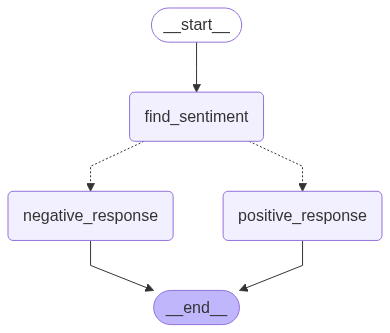

In [180]:
workflow

In [181]:
user_review = {
    'review': "Wow! The product was amaging, I loved it!",
}

In [182]:
result = workflow.invoke(user_review)

In [183]:
print(result)

{'review': 'Wow! The product was amaging, I loved it!', 'sentiment': 'positive', 'response': "We're thrilled that you had such an amazing experience with our product! It's great to hear that it exceeded your expectations and brought you joy. We're committed to providing high-quality products that make a difference in people's lives, and we appreciate your kind words. Thank you for choosing us - we look forward to serving you again in the future!"}
